In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import time

In [2]:
digits = torch.tensor([0, 1, 2, 3])
one_hot_digits = torch.nn.functional.one_hot(digits, num_classes=10)

print(one_hot_digits)


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


In [3]:
device = "cpu" #sue "cuda" if GPU is available

In [4]:
#Mnist data
#creating a dataloader
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/scratch/trose/mnist',
           transform=torchvision.transforms.ToTensor(),
           download=True),
    batch_size=128,
    shuffle=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:24<00:00, 13.21s/it]


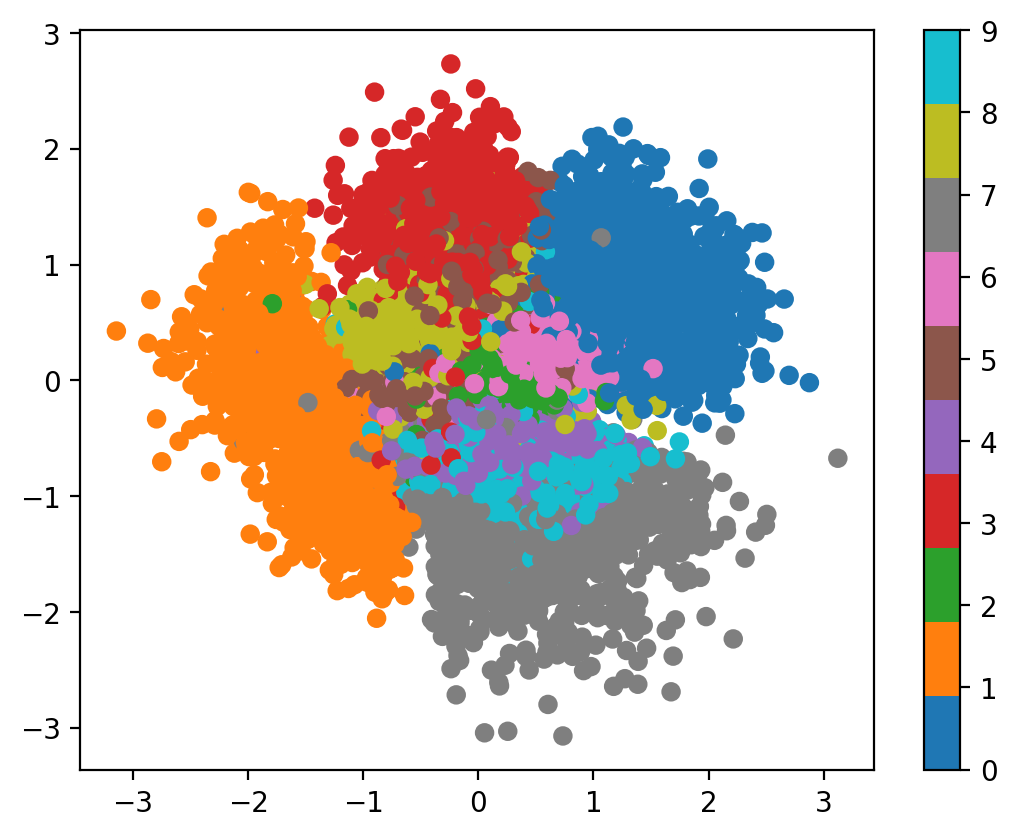

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, device):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.device = device
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape).to(self.device)
        self.k1 = ((sigma ** 2 + mu ** 2 - torch.log(sigma) - 1 / 2).sum())
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        x_hat = torch.sigmoid(self.linear2(z))
        return x_hat.reshape((-1, 1, 28, 28))

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, device):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims, device)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train_vae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, _ in data:
            x = x.to(device)  # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat) ** 2).sum() + autoencoder.encoder.k1
            loss.backward()
            opt.step()
    return autoencoder



def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

latent_dims = 2
vae = VariationalAutoencoder(latent_dims, device)
vae = train_vae(vae, data)

plot_latent(vae, data)